# Intro

This notebook is to validate **firing rate** and **spike count** generation.

It also validates **time normalization**.

---
# Setup

In [1]:
#%% imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from popy.io_tools import load_behavior, load_neural_data
from popy.neural_data_tools import time_normalize_session, set_off_recording_times_to_nan, add_firing_rates, remove_low_fr_neurons
from popy.decoding.decoder_tools import build_dataset

In [10]:
#%% helpers
def plot_firing_rate(neural_data, example_unit=None, tmin=100, tmax=110):
    if example_unit is None:
        example_unit = neural_data.unit[0]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax_ = ax.twinx()
    ax.set_title('Example unit')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Firing rate (Hz)')
    ax_.set_ylabel('Spike count (# spikes)')

    for data_variable in neural_data.data_vars:
        # plot only the example unit
        data_curr = neural_data[data_variable].sel(unit=example_unit, time=slice(tmin, tmax))
        if data_variable == 'spike_trains':
            ax_.eventplot(data_curr.time[data_curr==1], lineoffsets=0, linelengths=1, color='black', label=data_variable)
            # print stats
            print(f"mean {data_variable}: {data_curr.mean().values}, bin size: {neural_data.attrs['bin_size']} -> {data_curr.mean().values/neural_data.attrs['bin_size']} Hz")
        elif data_variable == 'firing_rates':
            ax.plot(data_curr.time, data_curr, label=data_variable, color='tab:green')
            print(f"mean {data_variable}: {data_curr.mean().values} ")
        elif data_variable == 'spike_counts':
            ax_.plot(data_curr.time, data_curr, label=data_variable, color='tab:orange')
            # print stats
            print(f"mean {data_variable}: {data_curr.mean().values} ")
    
    # Combine legends from both axes
    handles2, labels2 = ax.get_legend_handles_labels()
    handles, labels = ax_.get_legend_handles_labels()
    ax.legend(handles + handles2, labels + labels2, loc='upper right')


    ax.grid(axis='x')
    ax.set_ylim(bottom=0)
    ax_.set_ylim(bottom=0)
    

---
# Section 1: Firing rate and spike count generation

In [3]:
# pick session
monkey, session = 'ka', '210322'

# get neural data
neural_data = load_neural_data(monkey, session)  # spike data
neural_data = remove_low_fr_neurons(neural_data, 1)  # remove units with firing rate < 0.5 Hz

In [ ]:
# generate spike counts
win_len = 0.200
neural_data = add_firing_rates(neural_data, method='count', win_len=win_len)

# generate firing rates
std = 0.050
neural_data = add_firing_rates(neural_data, method='gauss', std=std)

mean spike_trains: 0.06387225548902195, bin size: 0.01 -> 6.387225548902195 Hz
mean spike_counts: 1.2774450778961182 
mean firing_rates: 6.402230739593506 


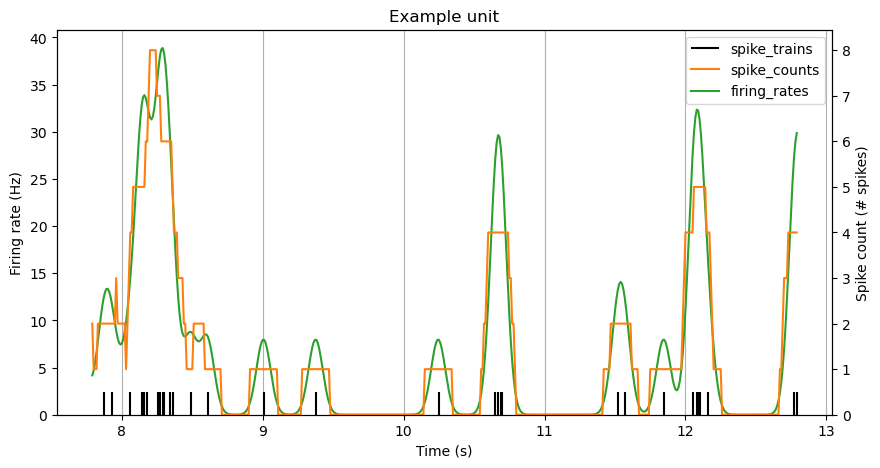

In [11]:
# plot example unit
tmin, tmax = neural_data.time[0], neural_data.time[0]+5
plot_firing_rate(neural_data, tmin=tmin, tmax=tmax)

In [6]:
# print statistics
print("N spikes in the window: ", neural_data['spike_trains'].sum().values)

N spikes in the window:  1059484.0


---
# TODO!!! Section 2: Time normalization

In [7]:
# time normalize the neural data
neural_data_norm = time_normalize_session(neural_data)

mean spike_trains: 0.02594810379241517, bin size: 0.01 -> 2.5948103792415167 Hz
mean spike_counts: 0.538922131061554 
mean firing_rates: 2.687971830368042 
mean spike_trains: 0.03454231433506045, bin size: 0.01 -> 3.454231433506045 Hz
mean spike_counts: 0.7806562781333923 
mean firing_rates: 4.233033559609653 


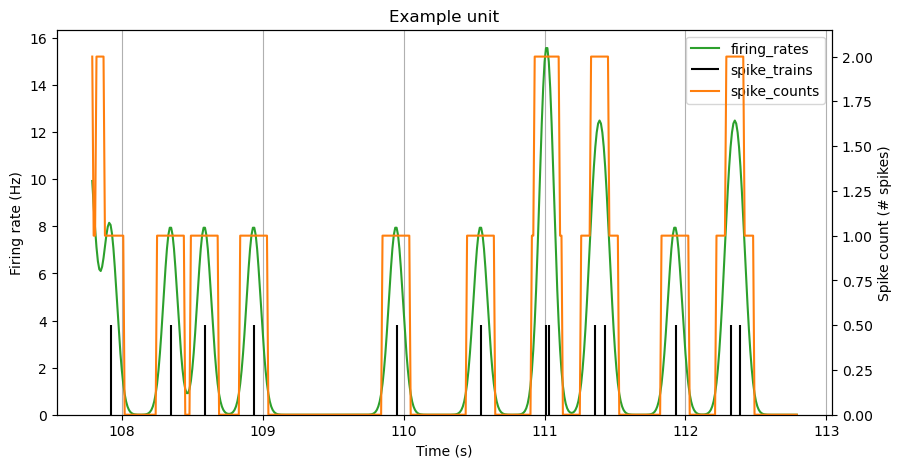

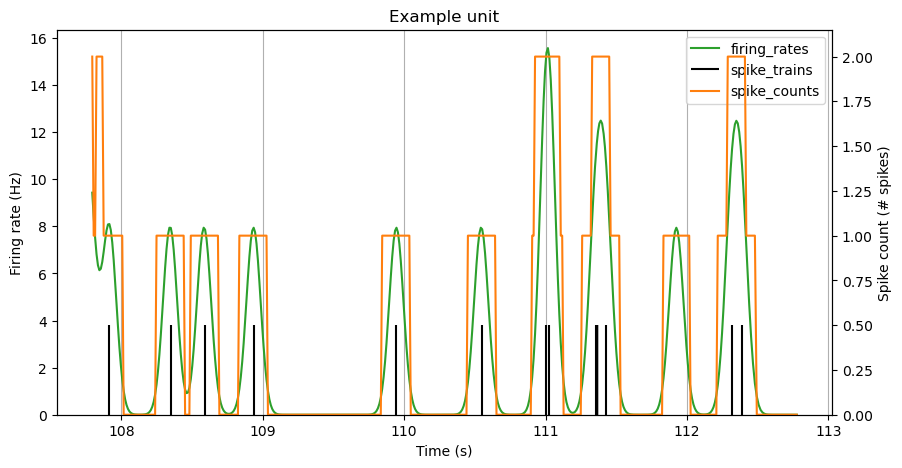

In [8]:
tmin, tmax = neural_data.time[10_000], neural_data.time[10_000]+5
plot_firing_rate(neural_data, tmin=tmin, tmax=tmax)
plot_firing_rate(neural_data_norm, tmin=tmin, tmax=tmax)

---
#  Below: to review 

## Inspect spike data

The spike data is stored in an xarray data array. It is essentially a numpy array where the dimensinos can have coordinates attached. The data is a 2 dimensional matrix, units by time. The coordinates store the following information:
- unit coodinates:
    - 'unit': eg MCC_05_01, where MCC is the area, 05 is the recording channel (01-16) nd 01 is the id of the unit on this channel (as some channels contain multiple units)
    - 'area': the recoding area, again
    - 'unit_id_original': Clement's id, to be comperable
    - 'channel': the channel information, again
- time coordinates:
    - 'time': absolute time
    - 'trial_id': trial in the session
    - 'epoch_id': this field gives information on the eopch (e.g. feedback, etc, not very useful here)

Matching behavior and neural data can be done by (a) time field or (b) trial id.

In [9]:
spikes

NameError: name 'spikes' is not defined

In [ ]:
# convert data to simple numpy
spikes_np = spikes.to_array().values.squeeze()
spikes_np.shape

In [ ]:
# access to coordinates
time_vector, unit_vector = spikes.time.values, spikes.unit.values
unit_vector.shape, time_vector.shape

In [ ]:
# raster plot
t0, t1 = 0, 10  # s
bin_size = 0.01  # s

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.imshow(spikes_np[:, int(t0/bin_size):int(t1/bin_size)], aspect='auto', cmap='gray_r')
plt.xlabel('Time (s)')
plt.ylabel('Neuron')
plt.xticks(np.arange(0, (t1-t0)/bin_size, 1/bin_size), np.arange(t0, t1, 1))
plt.yticks(np.arange(0, len(unit_vector), 1), unit_vector)
plt.title(f'Spike raster plot for {monkey} {session}')
plt.show()

## Inspect behavior

The behavior is stored in a pandas dataframe. Each row is a trial, and the columns are the following:
- 'trial_id'
- time fields: 'trial_start_time', 'lever_touch_time', 'lever_validation_time', 'target_touch_time', 'target_validation_time',
       'feedback_time', 'trial_end_time', 
- 'block_id': shows whoch trials belong to the same block (the best target is fixed during a block)
- 'best_target': target with best reward rate 70%
- 'target': selected target 
- 'feedback': received feedback (True=rewarded, False=non-rewarded) 
- 'history_of_feedback': not important
- 'value_function': value computed based on behavior
- 'phase': explore-transition-exploit, based on the number of times the same target was selected (0-5=search, 5-10=transition, 10+=repeat)

Matching behavior and neural data can be done by (a) time field or (b) trial id.

In [ ]:
behav.head()

# Example of matching behavioral and neural data

In [ ]:
# get all trials' data aound the feedback +/- 1 sec

fb_times = behav.feedback_time.values  # get the feedback times for each trial

# get the spike times aound the feedback
dataset = []
for i, t in enumerate(fb_times):
    t_min, t_max = t-1, t+1
    bins_of_interest = (spikes.time.values > t_min) & (spikes.time.values < t_max)  # get the bins of interest (fb +- 1s)
    dataset.append(spikes_np[:, bins_of_interest])
dataset = np.stack(dataset)
dataset.shape

In [ ]:
# get rates by moving average spike counts
window_size = 10  # bins
dataset_rates = np.empty((dataset.shape[0], dataset.shape[1], dataset.shape[2]-window_size+1))
for i, trial_data in enumerate(dataset):
    for j, unit_data in enumerate(trial_data):
        unit_rates = np.convolve(unit_data, np.ones(window_size)/window_size, mode='valid')
        dataset_rates[i, j] = unit_rates

In [ ]:
# plot positive and negative spike counts
labels = behav.feedback  # get the feedback labels
pos_data = dataset_rates[labels == 1]  # get the positive trials
neg_data = dataset_rates[labels == 0]  # get the negative trials

# plot the mean spike counts
plt.figure(figsize=(20, 10))
plt.plot(pos_data.mean(axis=0).mean(axis=0), label='Positive trials')
plt.plot(neg_data.mean(axis=0).mean(axis=0), label='Negative trials')
plt.axvline(100, color='k', linestyle='--', label='Feedback time')
plt.xlabel('Time (s)')
plt.xticks(np.arange(0, 200, 10), np.round(np.arange(-1, 1, 0.1), 1))
plt.ylabel('Mean spike count')
plt.legend()
plt.show()
